In [1]:
%cd /home/teresakim/fungiclef-2024/

/home/teresakim/fungiclef-2024


In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import pyspark.sql.functions as f
import pyspark.ml as ml
from pyspark.sql.functions import udf, col
from pyspark.sql.types import ArrayType, FloatType, IntegerType
import fungiclef.embedding.transforms as trans
from fungiclef.utils import get_spark

In [17]:
spark = get_spark(**{
    "spark.sql.parquet.enableVectorizedReader": False, 
})
display(spark)

24/04/28 06:08:35 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).


In [18]:
gcs_parquet_path = "gs://dsgt-clef-fungiclef-2024/data/parquet/"

# define the embedding path here
#------------resnet embedding (original)
# input_folder = f"DF20_300px_resnet18" # 295,938 total
# embedding_name = "ResNet"

# ------------resnet embedding (300px full set)
# input_folder = f"DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/resnet"
# embedding_name = "ResNet_300px"

# ------------dino embedding (300px full set 8x8)
# input_folder = "DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/dino_dct/data" # 356,738
# embedding_name = "DINO 8x8"

# ------------dino embedding (300px full set 16x16)
input_folder = "DF20_300px_and_DF21_300px_corrected_FULL_SET_embedding/dino_dct_16/data" # 356,738
embedding_name = "DINO 16x16"

# ------------clip embedding # TBD
# embedding_name = "CLIP"

embedding_df = spark.read.parquet(gcs_parquet_path+input_folder)
embedding_df.printSchema()
embedding_df.count()

root
 |-- image_path: string (nullable = true)
 |-- species: string (nullable = true)
 |-- dct_embedding: array (nullable = true)
 |    |-- element: float (containsNull = true)



356738

### option 1

In [19]:
# option 1: sampling by top 5 species

# count the occurrences of each species and order by the count descending
species_counts = embedding_df.groupBy("species").count().orderBy(col("count").desc())

# get the top 5 species
top_species = species_counts.limit(5).select("species").rdd.flatMap(lambda x: x).collect()

In [20]:
# define a sample fraction, example: 10%
sample_fraction = 1.0

# filter the original df to include only records from the top 5 species and sample from them
sampled_df = embedding_df.filter(col("species").isin(top_species)).sampleBy("species", fractions={x: sample_fraction for x in top_species})

sampled_df.show()

+--------------------+--------------------+--------------------+
|          image_path|             species|       dct_embedding|
+--------------------+--------------------+--------------------+
|2238551073-31821.jpg|  Bjerkandera adusta|[-21912.355, 1296...|
|2238583429-112837...|  Bjerkandera adusta|[-25138.283, 4504...|
|2542590575-201879...|  Bjerkandera adusta|[-16980.77, -2041...|
|2303159549-115909...|  Bjerkandera adusta|[-24264.416, 1520...|
|2558872916-276865...|  Bjerkandera adusta|[-20151.281, 6023...|
|2818064333-59764.jpg|  Bjerkandera adusta|[-18970.32, 16374...|
|2427874095-195820...|  Bjerkandera adusta|[-20108.484, 29.5...|
|2238532201-250509...|  Bjerkandera adusta|[-10336.508, 5970...|
|2238548591-253406...|  Bjerkandera adusta|[-18209.176, 1003...|
|2898626416-291641...|  Bjerkandera adusta|[-25916.615, -154...|
|2238532278-28421.jpg|  Bjerkandera adusta|[-17398.633, -960...|
|2521519867-350454...|  Bjerkandera adusta|[-18230.73, -9113...|
|2984624387-370804...|  B

In [21]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import StandardScaler

# Convert to Pandas DF
# pandas_df = sampled_df.select(["embeddings", "species"]).toPandas() # resnet
pandas_df = sampled_df.select(["dct_embedding", "species"]).toPandas() # dino

# Extract features and labels
# emb_df = np.stack(pandas_df["embeddings"].values) # resnet
emb_df = np.stack(pandas_df["dct_embedding"].values) # dino
scaled_emb = StandardScaler().fit_transform(emb_df)
labels = pandas_df["species"].tolist()

spark.stop()

In [22]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# apply t-SNE
tsne = TSNE(n_components=2, verbose=1, perplexity=30, n_iter=1000)
tsne_results = tsne.fit_transform(scaled_emb)



#dino 8x8
def plot_cluster(pandas_df, embeddings, algorithm_name):
    # Plot the data
    fig, ax = plt.subplots(figsize=(8.8, 4.8), dpi=200)
    fig.suptitle(
        f"{algorithm_name} projection of top 5 fungi species ({embedding_name})",
        fontsize=14,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["species"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["species"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species,
            s=4,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    fig.savefig(f"notebooks/evaluation/visuals/{embedding_name}_{algorithm_name}.png")
    plt.show()


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 9597 samples in 0.005s...
[t-SNE] Computed neighbors for 9597 samples in 3.271s...
[t-SNE] Computed conditional probabilities for sample 1000 / 9597
[t-SNE] Computed conditional probabilities for sample 2000 / 9597
[t-SNE] Computed conditional probabilities for sample 3000 / 9597
[t-SNE] Computed conditional probabilities for sample 4000 / 9597
[t-SNE] Computed conditional probabilities for sample 5000 / 9597
[t-SNE] Computed conditional probabilities for sample 6000 / 9597
[t-SNE] Computed conditional probabilities for sample 7000 / 9597
[t-SNE] Computed conditional probabilities for sample 8000 / 9597
[t-SNE] Computed conditional probabilities for sample 9000 / 9597
[t-SNE] Computed conditional probabilities for sample 9597 / 9597
[t-SNE] Mean sigma: 3.329385
[t-SNE] KL divergence after 250 iterations with early exaggeration: 111.616203
[t-SNE] KL divergence after 1000 iterations: 4.446006


In [23]:
def plot_cluster(pandas_df, embeddings, algorithm_name):
    # Plot the data
    fig, ax = plt.subplots(figsize=(8.8, 4.8), dpi=200)
    fig.suptitle(
        f"{algorithm_name} projection of top 5 fungi species ({embedding_name})",
        fontsize=14,
        weight="bold",
    )

    # Create a scatter plot, color-coded by new species_idx
    colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
    top_species_idx = pandas_df["species"].value_counts().nlargest(5).index
    species_to_color = {species: colors[i] for i, species in enumerate(top_species_idx)}

    # Map species IDs to colors for plotting
    color_list = pandas_df["species"].map(species_to_color).tolist()

    for species, color in species_to_color.items():
        # Select embeddings for the current species
        idx = pandas_df["species"] == species
        ax.scatter(
            embeddings[idx, 0],
            embeddings[idx, 1],
            c=color,
            # cmap="tab10",
            label=species,
            s=4,
            alpha=0.7,
            linewidth=0.5,
        )

    ax.grid(color="blue", linestyle="--", linewidth=1, alpha=0.2)
    ax.legend(loc="best", title="Species Name", fontsize="small")
    for spine in ["top", "right", "bottom", "left"]:
        ax.spines[spine].set_visible(False)
    fig.tight_layout()
    fig.savefig(f"notebooks/evaluation/visuals/{embedding_name}_{algorithm_name}.png")
    plt.show()

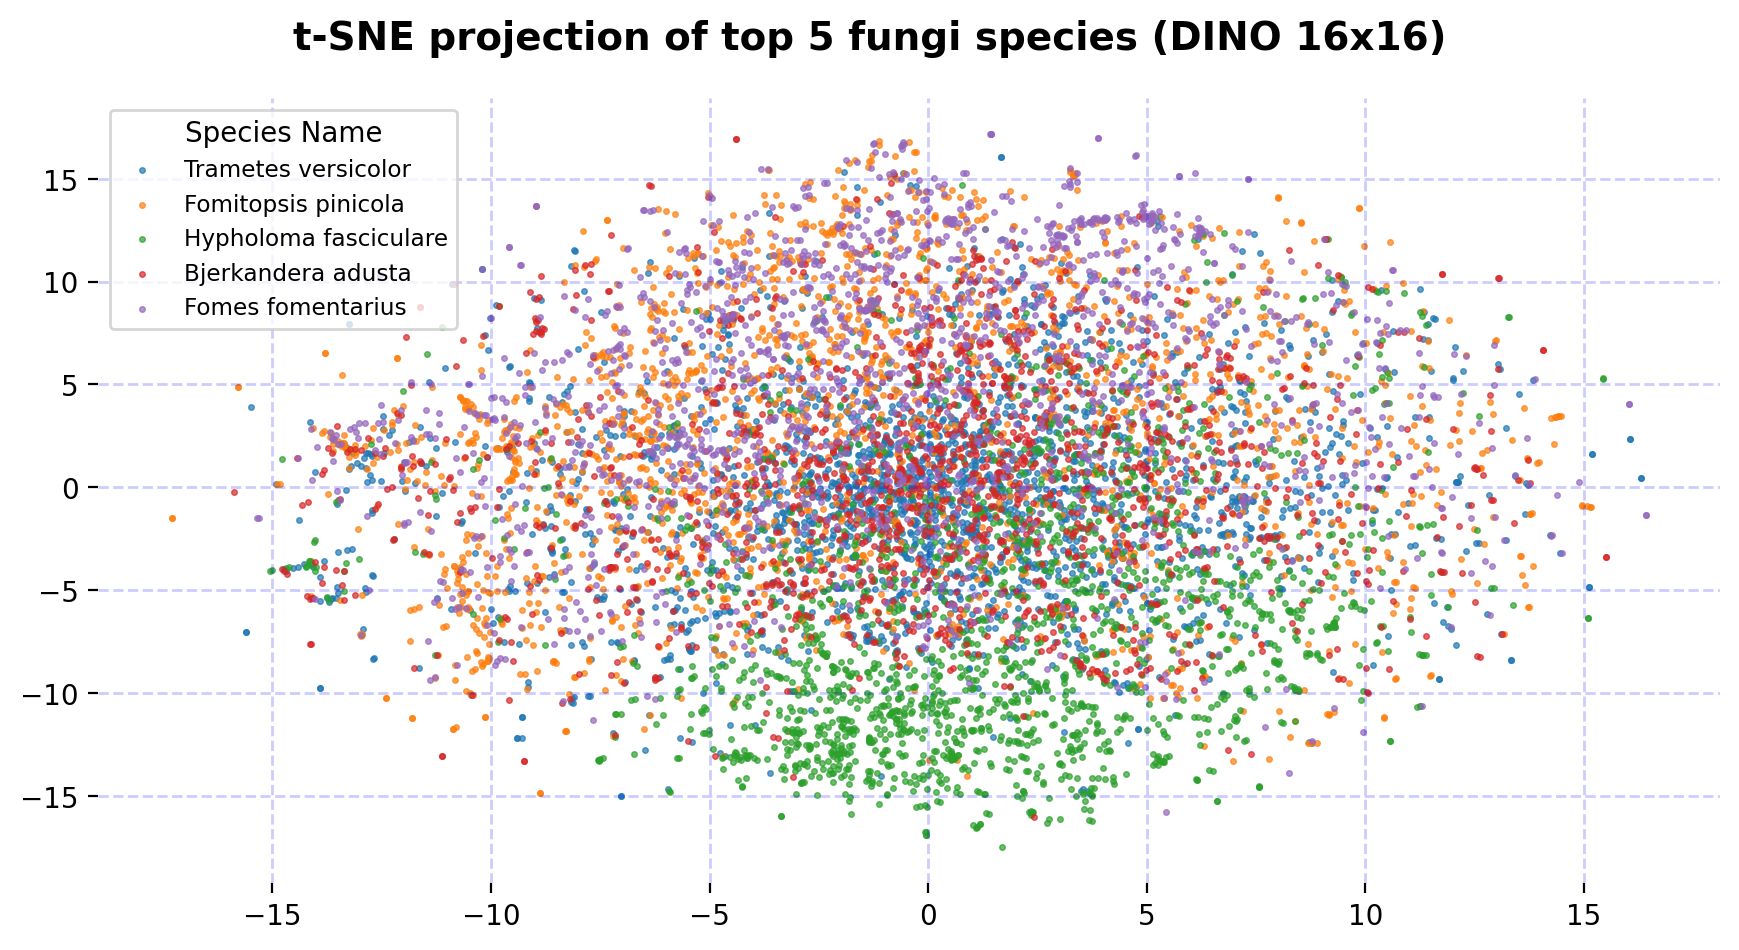

In [24]:
plot_cluster(pandas_df, tsne_results, algorithm_name="t-SNE")


In [ ]:
# resnet
# [t-SNE] Computing 91 nearest neighbors...
# [t-SNE] Indexed 9597 samples in 0.031s...
# [t-SNE] Computed neighbors for 9597 samples in 14.596s...
# [t-SNE] Computed conditional probabilities for sample 1000 / 9597
# [t-SNE] Computed conditional probabilities for sample 2000 / 9597
# [t-SNE] Computed conditional probabilities for sample 3000 / 9597
# [t-SNE] Computed conditional probabilities for sample 4000 / 9597
# [t-SNE] Computed conditional probabilities for sample 5000 / 9597
# [t-SNE] Computed conditional probabilities for sample 6000 / 9597
# [t-SNE] Computed conditional probabilities for sample 7000 / 9597
# [t-SNE] Computed conditional probabilities for sample 8000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9597 / 9597
# [t-SNE] Mean sigma: 8.020381
# [t-SNE] KL divergence after 250 iterations with early exaggeration: 93.062561
# [t-SNE] KL divergence after 1000 iterations: 3.017685

# dino 8x8
# [t-SNE] Computing 91 nearest neighbors...
# [t-SNE] Indexed 9597 samples in 0.001s...
# [t-SNE] Computed neighbors for 9597 samples in 2.311s...
# [t-SNE] Computed conditional probabilities for sample 1000 / 9597
# [t-SNE] Computed conditional probabilities for sample 2000 / 9597
# [t-SNE] Computed conditional probabilities for sample 3000 / 9597
# [t-SNE] Computed conditional probabilities for sample 4000 / 9597
# [t-SNE] Computed conditional probabilities for sample 5000 / 9597
# [t-SNE] Computed conditional probabilities for sample 6000 / 9597
# [t-SNE] Computed conditional probabilities for sample 7000 / 9597
# [t-SNE] Computed conditional probabilities for sample 8000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9597 / 9597
# [t-SNE] Mean sigma: 1.872417
# [t-SNE] KL divergence after 250 iterations with early exaggeration: 92.468254
# [t-SNE] KL divergence after 1000 iterations: 3.987825

# dino 16x16
# [t-SNE] Computing 91 nearest neighbors...
# [t-SNE] Indexed 9597 samples in 0.005s...
# [t-SNE] Computed neighbors for 9597 samples in 3.271s...
# [t-SNE] Computed conditional probabilities for sample 1000 / 9597
# [t-SNE] Computed conditional probabilities for sample 2000 / 9597
# [t-SNE] Computed conditional probabilities for sample 3000 / 9597
# [t-SNE] Computed conditional probabilities for sample 4000 / 9597
# [t-SNE] Computed conditional probabilities for sample 5000 / 9597
# [t-SNE] Computed conditional probabilities for sample 6000 / 9597
# [t-SNE] Computed conditional probabilities for sample 7000 / 9597
# [t-SNE] Computed conditional probabilities for sample 8000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9000 / 9597
# [t-SNE] Computed conditional probabilities for sample 9597 / 9597
# [t-SNE] Mean sigma: 3.329385
# [t-SNE] KL divergence after 250 iterations with early exaggeration: 111.616203
# [t-SNE] KL divergence after 1000 iterations: 4.446006

### option 2